In [37]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten, Convolution1D, Dropout, MaxPooling1D, BatchNormalization, \
    Activation, Reshape, GlobalMaxPooling1D, LSTM, GlobalAveragePooling1D, AveragePooling1D, SeparableConvolution1D, \
    Concatenate, Layer, Conv2D
from tensorflow.keras.models import Sequential
import random
import sklearn
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam, SGD

In [39]:
(train_x, train_y), (test_x, test_y) = boston_housing.load_data()
sc = StandardScaler()

train_x = sc.fit_transform(train_x)
test_x = sc.fit_transform(test_x)
print(train_x[0])
print(train_y[0])

[-0.27224633 -0.48361547 -0.43576161 -0.25683275 -0.1652266  -0.1764426
  0.81306188  0.1166983  -0.62624905 -0.59517003  1.14850044  0.44807713
  0.8252202 ]
15.2


In [44]:
model = Sequential()#先建立一个顺序模型
model.add(Dense(256, activation='relu', input_shape=(13,)))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(1)) #因为我们是预测房价，不是分类，所以最后一层可以不用激活函数

print(model.summary())


def MyModel():
    # 16*64 维数是16 特征长度是64
    input = tf.keras.Input(shape=(13,))
    x = Dense(256,activation="relu")(input)
    x = Dense(256,activation="relu")(x)
    output = Dense(1)(x)
    model = tf.keras.Model(input, output)
    print(model.summary())

    return model

model = MyModel()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_38 (Dense)            (None, 256)               3584      
                                                                 
 dense_39 (Dense)            (None, 64)                16448     
                                                                 
 dense_40 (Dense)            (None, 32)                2080      
                                                                 
 dense_41 (Dense)            (None, 1)                 33        
                                                                 
Total params: 22145 (86.50 KB)
Trainable params: 22145 (86.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param 

In [46]:
model.compile(optimizer='adam', loss='mse', metrics=['mae'])
model.fit(train_x,train_y,epochs=500,batch_size=64,validation_data=(test_x, test_y))

Epoch 1/500
7/7 [==============================] - 1s 32ms/step - loss: 1.6938 - mae: 0.9964 - val_loss: 13.6247 - val_mae: 2.7096
Epoch 2/500
7/7 [==============================] - 0s 8ms/step - loss: 1.1338 - mae: 0.7843 - val_loss: 15.3121 - val_mae: 2.8550
Epoch 3/500
7/7 [==============================] - 0s 9ms/step - loss: 0.9377 - mae: 0.7361 - val_loss: 13.8439 - val_mae: 2.7503
Epoch 4/500
7/7 [==============================] - 0s 9ms/step - loss: 0.7410 - mae: 0.6373 - val_loss: 14.0658 - val_mae: 2.7157
Epoch 5/500
7/7 [==============================] - 0s 11ms/step - loss: 0.6757 - mae: 0.5775 - val_loss: 13.8266 - val_mae: 2.6826
Epoch 6/500
7/7 [==============================] - 0s 14ms/step - loss: 0.6616 - mae: 0.5910 - val_loss: 14.4013 - val_mae: 2.7956
Epoch 7/500
7/7 [==============================] - 0s 12ms/step - loss: 0.7604 - mae: 0.6234 - val_loss: 15.1291 - val_mae: 2.8884
Epoch 8/500
7/7 [==============================] - 0s 8ms/step - loss: 0.6743 - mae: 0

4/4 [==============================] - 0s 3ms/step


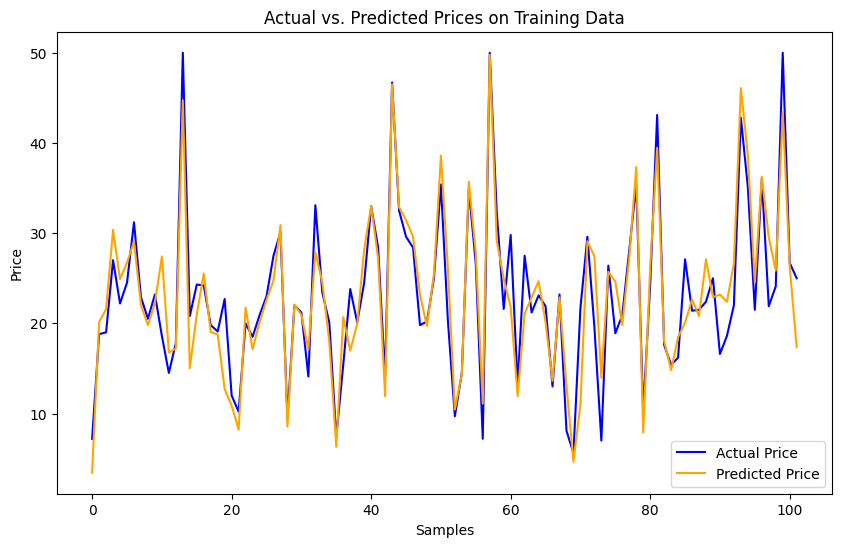

In [47]:
import matplotlib.pyplot as plt

# 对训练集进行预测
test_predictions = model.predict(test_x).flatten()

# 绘制预测值和实际值的曲线关系图
plt.figure(figsize=(10, 6))
plt.plot(test_y, label='Actual Price', color='blue')
plt.plot(test_predictions, label='Predicted Price', color='orange')
plt.xlabel('Samples')
plt.ylabel('Price')
plt.title('Actual vs. Predicted Prices on Training Data')
plt.legend()
plt.show()


# 模型转换

In [50]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
open("bostom_model.tflite", "wb").write(tflite_model)

280384

# tflite 推理

In [54]:
import numpy as np
x = train_x[10]
y = train_y[10]

print(y)

x = np.array(x).astype('float32').reshape(13,1)
print(x)

interpreter = tf.lite.Interpreter(model_path="bostom_model.tflite")
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()


interpreter.resize_tensor_input(input_details[0]['index'], x.shape)
interpreter.allocate_tensors()

interpreter.set_tensor(input_details[0]['index'], x)
interpreter.invoke()
output_data = interpreter.get_tensor(output_details[0]['index'])

print(output_data)

12.1
[[ 0.6339165 ]
 [-0.48361546]
 [ 1.0283258 ]
 [-0.25683275]
 [ 1.1578878 ]
 [ 0.19313958]
 [ 1.1104883 ]
 [-1.0362827 ]
 [ 1.6758858 ]
 [ 1.5652875 ]
 [ 0.7844764 ]
 [ 0.22689421]
 [ 1.0446649 ]]
[[11.314066]]


In [53]:
!apt-get -qq install xxd
!xxd -i bostom_model.tflite > bostom_model.cc